# EqualWidthMinimumWeightBinning: Feature Demonstration

This notebook demonstrates the key features of the `EqualWidthMinimumWeightBinning` class from the binlearn library.

## Key Features Covered:
- Basic binning with weight constraints
- Different weight distributions and their effects
- Working with survey data and importance sampling
- Sklearn pipeline integration
- Parameter serialization and reconstruction
- Edge case handling

## Overview
`EqualWidthMinimumWeightBinning` creates equal-width bins while ensuring each bin meets minimum weight requirements, making it ideal for:
- **Survey data** with respondent weights
- **Importance sampling** scenarios
- **Weighted statistical analysis**
- **Sample size constraints** with varying importance

## 1. Setup and Data Preparation

In [33]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from binlearn.methods import EqualWidthMinimumWeightBinning
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [34]:
# Create sample datasets with different weight scenarios
n_samples = 300

# 1. Survey data with respondent weights
age = np.random.uniform(18, 80, n_samples)
income = np.random.uniform(20000, 150000, n_samples)
satisfaction = np.random.uniform(1, 10, n_samples)

# Create realistic respondent weights (some demographics underrepresented)
respondent_weights = np.ones(n_samples)
# Older adults underrepresented - higher weights
respondent_weights[age > 65] *= 2.5
# Young adults underrepresented - higher weights  
respondent_weights[age < 25] *= 2.0
# High income underrepresented - higher weights
respondent_weights[income > 100000] *= 1.8
# Add some random variation
respondent_weights *= np.random.uniform(0.8, 1.2, n_samples)

df_survey = pd.DataFrame({
    'age': age,
    'income': income,
    'satisfaction_score': satisfaction,
    'respondent_weight': respondent_weights
})

# 2. Importance sampling scenario
x_importance = np.random.uniform(-3, 3, n_samples)
y_importance = x_importance**2 + 0.5 * np.random.normal(0, 1, n_samples)

# Create importance weights (higher for extreme values)
importance_weights = 1.0 / (1.0 + np.exp(-2 * np.abs(x_importance)))
importance_weights *= 5  # Scale up

df_importance = pd.DataFrame({
    'feature_x': x_importance,
    'feature_y': np.random.uniform(-2, 2, n_samples),
    'target': y_importance,
    'importance_weight': importance_weights
})

# 3. Sparse weight scenario (many small weights, few large ones)
sparse_feature = np.random.uniform(0, 100, n_samples)
sparse_weights = np.random.exponential(1.0, n_samples)  # Exponential distribution
# Make 80% of weights very small, 20% larger
small_weight_mask = np.random.choice(n_samples, size=int(0.8 * n_samples), replace=False)
sparse_weights[small_weight_mask] *= 0.1

df_sparse = pd.DataFrame({
    'measurement': sparse_feature,
    'auxiliary_feature': np.random.uniform(-5, 5, n_samples),
    'sample_weight': sparse_weights
})

# 4. NumPy array for basic demonstration
array_data = np.column_stack([age[:100], income[:100], respondent_weights[:100]])

print(f"📊 Created datasets:")
print(f"   - Survey data: {df_survey.shape}")
print(f"   - Importance sampling: {df_importance.shape}")
print(f"   - Sparse weights: {df_sparse.shape}")
print(f"   - Array data: {array_data.shape}")

# Show weight statistics
print(f"\n📈 Weight distributions:")
for name, df, weight_col in [
    ('Survey', df_survey, 'respondent_weight'),
    ('Importance', df_importance, 'importance_weight'),
    ('Sparse', df_sparse, 'sample_weight')
]:
    weights = df[weight_col]
    print(f"   {name}: min={weights.min():.2f}, mean={weights.mean():.2f}, "
          f"max={weights.max():.2f}, std={weights.std():.2f}")

📊 Created datasets:
   - Survey data: (300, 4)
   - Importance sampling: (300, 4)
   - Sparse weights: (300, 3)
   - Array data: (100, 3)

📈 Weight distributions:
   Survey: min=0.81, mean=2.00, max=5.37, std=1.11
   Importance: min=2.52, mean=4.43, max=4.99, std=0.69
   Sparse: min=0.00, mean=0.30, max=3.97, std=0.61


## 2. Basic Binning Operations

In [35]:
# Basic weight-constrained binning for survey data
print("🎯 Basic EqualWidthMinimumWeightBinning - Survey Data")
print("=" * 55)

# Create and fit binner with weight constraints
binner_survey = EqualWidthMinimumWeightBinning(
    n_bins=6,
    minimum_weight=15.0,  # Minimum total weight per bin
    guidance_columns=['respondent_weight']
)
binner_survey.fit(df_survey)

# Transform data
binned_survey = binner_survey.transform(df_survey[['age', 'income', 'satisfaction_score']])

print(f"📊 Bin edges created:")
for col, edges in binner_survey.bin_edges_.items():
    edges_array = np.array(edges)  # Ensure it's a numpy array
    if col == 'income':
        print(f"   {col}: {len(edges)-1} bins, edges: {np.round(edges_array/1000, 0).astype(int)}k")
    else:
        print(f"   {col}: {len(edges)-1} bins, edges: {np.round(edges_array, 1)}")

print(f"\n🔢 Binned data shape: {binned_survey.shape}")

# Verify weight constraints are met
print(f"\n⚖️ Weight verification (age feature):")
age_binned = binned_survey[:, 0]
for bin_id in np.unique(age_binned):
    mask = age_binned == bin_id
    total_weight = df_survey.loc[mask, 'respondent_weight'].sum()
    count = mask.sum()
    avg_age = df_survey.loc[mask, 'age'].mean()
    print(f"   Bin {int(bin_id)} (age ~{avg_age:.0f}): {count} samples, total weight: {total_weight:.1f}")
    
min_weight_achieved = min([df_survey.loc[age_binned == bin_id, 'respondent_weight'].sum() 
                          for bin_id in np.unique(age_binned)])
print(f"\n✅ Minimum weight constraint (≥{binner_survey.minimum_weight}): {min_weight_achieved:.1f} achieved")

🎯 Basic EqualWidthMinimumWeightBinning - Survey Data
📊 Bin edges created:
   age: 6 bins, edges: [18.3 28.5 38.7 48.8 59.  69.2 79.4]
   income: 6 bins, edges: [ 21  43  64  86 107 129 150]k
   satisfaction_score: 6 bins, edges: [ 1.   2.5  4.   5.5  7.   8.5 10. ]

🔢 Binned data shape: (300, 3)

⚖️ Weight verification (age feature):
   Bin 0 (age ~23): 53 samples, total weight: 121.4
   Bin 1 (age ~34): 56 samples, total weight: 78.5
   Bin 2 (age ~43): 35 samples, total weight: 44.2
   Bin 3 (age ~54): 56 samples, total weight: 80.3
   Bin 4 (age ~64): 48 samples, total weight: 106.9
   Bin 5 (age ~75): 52 samples, total weight: 167.6

✅ Minimum weight constraint (≥15.0): 44.2 achieved


In [36]:
# Importance sampling scenario
print("\n🎯 Importance Sampling Binning")
print("=" * 35)

# Create binner for importance sampling
binner_importance = EqualWidthMinimumWeightBinning(
    n_bins=5,
    minimum_weight=8.0,
    guidance_columns=['importance_weight']
)
binner_importance.fit(df_importance)

# Transform and analyze
binned_importance = binner_importance.transform(df_importance)

print(f"📊 Importance sampling bins:")
for col, edges in binner_importance.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, range: [{edges[0]:.2f}, {edges[-1]:.2f}]")

# Compare with unweighted equal-width binning
print(f"\n📈 Comparison with unweighted binning:")
from binlearn.methods import EqualWidthBinning

binner_unweighted = EqualWidthBinning(n_bins=5)
binner_unweighted.fit(df_importance[['feature_x', 'feature_y']])

print(f"   Weighted bins (feature_x): {len(binner_importance.bin_edges_['feature_x'])-1}")
print(f"   Unweighted bins (feature_x): {len(binner_unweighted.bin_edges_['feature_x'])-1}")

# Show weight distribution across bins
x_binned = binned_importance[:, 0]
print(f"\n⚖️ Feature_x weight distribution:")
for bin_id in np.unique(x_binned):
    mask = x_binned == bin_id
    total_weight = df_importance.loc[mask, 'importance_weight'].sum()
    count = mask.sum()
    print(f"   Bin {int(bin_id)}: {count} samples, weight: {total_weight:.1f}")

# Demonstrate with numpy arrays
print(f"\n🔢 NumPy Array Support:")
binner_array = EqualWidthMinimumWeightBinning(
    n_bins=4, minimum_weight=5.0, guidance_columns=[2]
)
binner_array.fit(array_data)
binned_array = binner_array.transform(array_data)
print(f"   Array shape: {array_data.shape} → {binned_array.shape}")
print(f"   Unique values: {len(np.unique(binned_array))}")


🎯 Importance Sampling Binning
📊 Importance sampling bins:
   feature_x: 5 bins, range: [-2.97, 3.00]
   feature_y: 5 bins, range: [-1.99, 1.99]
   target: 5 bins, range: [-1.08, 9.47]

📈 Comparison with unweighted binning:
   Weighted bins (feature_x): 5
   Unweighted bins (feature_x): 5

⚖️ Feature_x weight distribution:
   Bin 0: 65 samples, weight: 321.6
   Bin 1: 51 samples, weight: 229.0
   Bin 2: 58 samples, weight: 184.5
   Bin 3: 68 samples, weight: 306.1
   Bin 4: 58 samples, weight: 287.1

🔢 NumPy Array Support:
   Array shape: (100, 3) → (100, 2)
   Unique values: 4


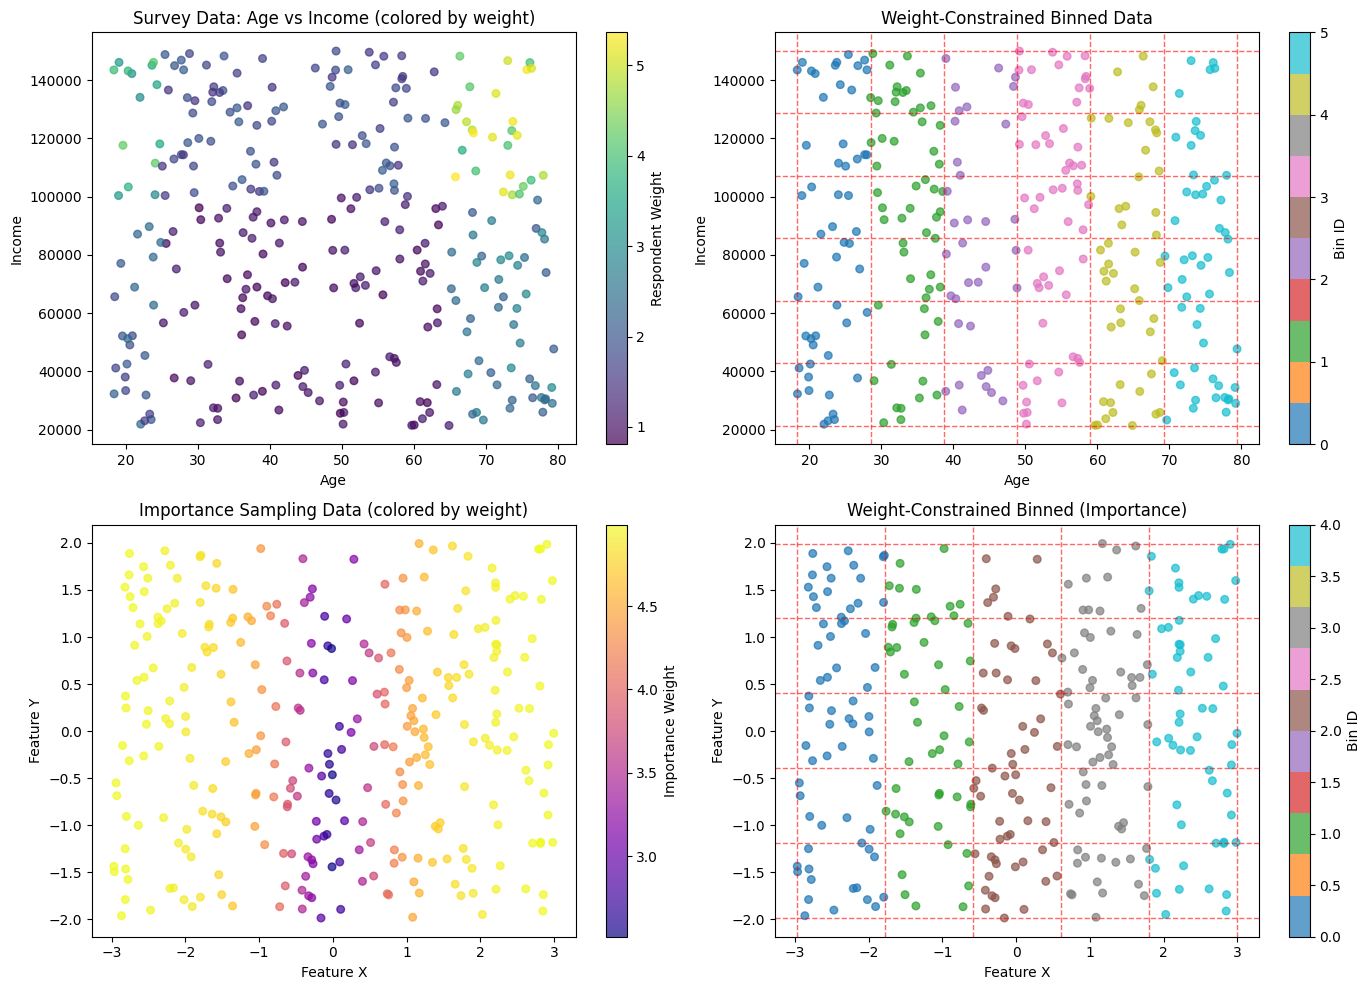

In [37]:
# Visualize weight-constrained binning results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Original survey data with weights as color
scatter1 = ax1.scatter(df_survey['age'], df_survey['income'], 
                      c=df_survey['respondent_weight'], 
                      cmap='viridis', alpha=0.7, s=30)
ax1.set_title('Survey Data: Age vs Income (colored by weight)')
ax1.set_xlabel('Age')
ax1.set_ylabel('Income')
plt.colorbar(scatter1, ax=ax1, label='Respondent Weight')

# Binned survey data with boundaries
binned_vis = binner_survey.transform(df_survey)
scatter2 = ax2.scatter(df_survey['age'], df_survey['income'], 
                      c=binned_vis[:, 0], cmap='tab10', alpha=0.7, s=30)

# Add bin boundaries
for edge in binner_survey.bin_edges_['age']:
    ax2.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)
for edge in binner_survey.bin_edges_['income']:
    ax2.axhline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax2.set_title('Weight-Constrained Binned Data')
ax2.set_xlabel('Age')
ax2.set_ylabel('Income')
plt.colorbar(scatter2, ax=ax2, label='Bin ID')

# Original importance sampling data
scatter3 = ax3.scatter(df_importance['feature_x'], df_importance['feature_y'], 
                      c=df_importance['importance_weight'], 
                      cmap='plasma', alpha=0.7, s=30)
ax3.set_title('Importance Sampling Data (colored by weight)')
ax3.set_xlabel('Feature X')
ax3.set_ylabel('Feature Y')
plt.colorbar(scatter3, ax=ax3, label='Importance Weight')

# Binned importance sampling data
binned_imp_vis = binner_importance.transform(df_importance)
scatter4 = ax4.scatter(df_importance['feature_x'], df_importance['feature_y'], 
                      c=binned_imp_vis[:, 0], cmap='tab10', alpha=0.7, s=30)

# Add bin boundaries
for edge in binner_importance.bin_edges_['feature_x']:
    ax4.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)
for edge in binner_importance.bin_edges_['feature_y']:
    ax4.axhline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax4.set_title('Weight-Constrained Binned (Importance)')
ax4.set_xlabel('Feature X')
ax4.set_ylabel('Feature Y')
plt.colorbar(scatter4, ax=ax4, label='Bin ID')

plt.tight_layout()
plt.show()

## 3. Weight Distribution Effects

In [38]:
# Demonstrate different minimum weight requirements
print("⚖️ Minimum Weight Parameter Effects")
print("=" * 40)

# Test different minimum weight values
weight_configs = {
    'Very Loose': 5.0,
    'Loose': 10.0,
    'Moderate': 15.0,
    'Strict': 25.0,
    'Very Strict': 40.0
}

total_weight = df_survey['respondent_weight'].sum()
print(f"Total available weight: {total_weight:.1f}")

results = {}
for config_name, min_weight in weight_configs.items():
    print(f"\n🎯 {config_name} (min_weight = {min_weight}):")
    
    try:
        # Create binner with specific minimum weight
        binner = EqualWidthMinimumWeightBinning(
            n_bins=8,  # Request 8 bins
            minimum_weight=min_weight,
            guidance_columns=['respondent_weight']
        )
        
        # Fit and analyze
        binner.fit(df_survey)
        
        # Count actual bins created
        age_bins = len(binner.bin_edges_['age']) - 1
        income_bins = len(binner.bin_edges_['income']) - 1
        
        results[config_name] = {
            'min_weight': min_weight,
            'age_bins': age_bins,
            'income_bins': income_bins,
            'total_bins': age_bins + income_bins
        }
        
        print(f"   Requested bins: 8, Age bins created: {age_bins}, Income bins: {income_bins}")
        print(f"   Total bins: {age_bins + income_bins}")
        
        # Check if constraints forced bin merging
        if age_bins < 8:
            print(f"   ⚠️ Weight constraints forced bin merging (age: {8-age_bins} merges)")
        else:
            print(f"   ✅ All requested bins created")
            
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")
        results[config_name] = {'error': str(e)}

# Summary comparison
print(f"\n📊 Weight Constraint Effects Summary:")
print(f"   {'Config':<12} {'Min Weight':<12} {'Age Bins':<10} {'Income Bins':<12} {'Effect'}")
print(f"   {'-'*70}")
for config, result in results.items():
    if 'error' not in result:
        effect = "Heavy merging" if result['age_bins'] <= 3 else "Some merging" if result['age_bins'] <= 6 else "No merging"
        print(f"   {config:<12} {result['min_weight']:<12} {result['age_bins']:<10} {result['income_bins']:<12} {effect}")
    else:
        print(f"   {config:<12} {'-':<12} {'-':<10} {'-':<12} Error")

⚖️ Minimum Weight Parameter Effects
Total available weight: 598.9

🎯 Very Loose (min_weight = 5.0):
   Requested bins: 8, Age bins created: 8, Income bins: 8
   Total bins: 16
   ✅ All requested bins created

🎯 Loose (min_weight = 10.0):
   Requested bins: 8, Age bins created: 8, Income bins: 8
   Total bins: 16
   ✅ All requested bins created

🎯 Moderate (min_weight = 15.0):
   Requested bins: 8, Age bins created: 8, Income bins: 8
   Total bins: 16
   ✅ All requested bins created

🎯 Strict (min_weight = 25.0):
   Requested bins: 8, Age bins created: 8, Income bins: 8
   Total bins: 16
   ✅ All requested bins created

🎯 Very Strict (min_weight = 40.0):
   Requested bins: 8, Age bins created: 7, Income bins: 8
   Total bins: 15
   ⚠️ Weight constraints forced bin merging (age: 1 merges)

📊 Weight Constraint Effects Summary:
   Config       Min Weight   Age Bins   Income Bins  Effect
   ----------------------------------------------------------------------
   Very Loose   5.0          8

## 4. Sklearn Pipeline Integration

In [39]:
# Demonstrate pipeline integration
print("🔗 Sklearn Pipeline Integration")
print("=" * 35)

# Split survey data for regression (predicting satisfaction)
X_train, X_test, y_train, y_test = train_test_split(
    df_survey[['age', 'income']], 
    df_survey['satisfaction_score'], 
    test_size=0.3, 
    random_state=42
)

# Get corresponding weights for training data
train_indices = X_train.index
train_weights = df_survey.loc[train_indices, 'respondent_weight']

# Create pipeline with weight-constrained binning and regression
pipeline = Pipeline([
    ('binner', EqualWidthMinimumWeightBinning(
        n_bins=5,
        minimum_weight=10.0
    )),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])

# Fit with weights as guidance data
pipeline.fit(X_train, y_train, binner__guidance_data=train_weights.values)
y_pred = pipeline.predict(X_test)
mse = np.mean((y_pred - y_test)**2)
r2 = 1 - mse / np.var(y_test)

print(f"✅ Pipeline trained successfully")
print(f"📊 Test R² score: {r2:.3f}")
print(f"📊 Test MSE: {mse:.3f}")
print(f"🔢 Features binned: {X_train.shape[1]}")

# Show bin edges from pipeline
binner_from_pipeline = pipeline.named_steps['binner']
print(f"\n📏 Bin edges created:")
for col, edges in binner_from_pipeline.bin_edges_.items():
    if col == 'age':
        print(f"   Age: {len(edges)-1} bins, range: [{edges[0]:.0f}, {edges[-1]:.0f}]")
    else:
        print(f"   Income: {len(edges)-1} bins, range: [{edges[0]/1000:.0f}k, {edges[-1]/1000:.0f}k]")

# Compare with unweighted equal-width binning
from binlearn.methods import EqualWidthBinning

pipeline_unweighted = Pipeline([
    ('binner', EqualWidthBinning(n_bins=5)),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])

pipeline_unweighted.fit(X_train, y_train)
y_pred_unweighted = pipeline_unweighted.predict(X_test)
mse_unweighted = np.mean((y_pred_unweighted - y_test)**2)
r2_unweighted = 1 - mse_unweighted / np.var(y_test)

print(f"\n📈 Comparison with EqualWidthBinning:")
print(f"   Weight-constrained R²: {r2:.3f}")
print(f"   Standard equal-width R²: {r2_unweighted:.3f}")
print(f"   Difference: {r2 - r2_unweighted:+.3f}")

# Analyze bin weight distributions from pipeline
print(f"\n⚖️ Pipeline bin weight verification:")
binned_train = binner_from_pipeline.transform(X_train)
age_binned_train = binned_train[:, 0]
for bin_id in np.unique(age_binned_train):
    mask = age_binned_train == bin_id
    bin_weight = train_weights.iloc[mask].sum()
    print(f"   Age bin {int(bin_id)}: weight = {bin_weight:.1f}")

🔗 Sklearn Pipeline Integration
✅ Pipeline trained successfully
📊 Test R² score: -0.306
📊 Test MSE: 7.821
🔢 Features binned: 2

📏 Bin edges created:
   Age: 5 bins, range: [18, 79]
   Income: 5 bins, range: [21k, 148k]

📈 Comparison with EqualWidthBinning:
   Weight-constrained R²: -0.306
   Standard equal-width R²: -0.306
   Difference: +0.000

⚖️ Pipeline bin weight verification:
   Age bin 0: weight = 101.2
   Age bin 1: weight = 57.1
   Age bin 2: weight = 42.4
   Age bin 3: weight = 69.5
   Age bin 4: weight = 158.3


## 5. Parameter Serialization and Reconstruction

In [40]:
# Demonstrate serialization for model persistence
print("💾 Parameter Serialization & Reconstruction")
print("=" * 45)

# Create and fit original binner
original_binner = EqualWidthMinimumWeightBinning(
    n_bins=6,
    minimum_weight=12.0,
    bin_range=None,  # Auto-detect range
    guidance_columns=['respondent_weight']
)
original_binner.fit(df_survey)
original_result = original_binner.transform(df_survey)

# Serialize parameters
params = original_binner.get_params()
print(f"📋 Serialized parameters: {params}")

# Reconstruct binner from parameters
reconstructed_binner = EqualWidthMinimumWeightBinning(**params)

# Test reconstruction
reconstructed_result = reconstructed_binner.transform(df_survey)
results_match = np.allclose(original_result, reconstructed_result)

print(f"\n🔍 Reconstruction verification:")
print(f"   ✅ Results identical: {results_match}")
print(f"   📊 Original shape: {original_result.shape}")
print(f"   📊 Reconstructed shape: {reconstructed_result.shape}")

# Test with new survey data (without refitting)
new_age = np.random.uniform(20, 70, 60)
new_income = np.random.uniform(25000, 120000, 60)
new_satisfaction = np.random.uniform(2, 9, 60)

df_new_survey = pd.DataFrame({
    'age': new_age,
    'income': new_income,
    'satisfaction_score': new_satisfaction
})

test_result = reconstructed_binner.transform(df_new_survey)
print(f"\n🔄 Transform new survey data without refitting:")
print(f"   ✅ Success: {test_result.shape}")
print(f"   🔢 Unique bins: {len(np.unique(test_result))}")

# Verify bin edges are preserved
print(f"\n📏 Bin edges preservation check:")
for col in ['age', 'income', 'satisfaction_score']:
    original_edges = original_binner.bin_edges_[col]
    reconstructed_edges = reconstructed_binner.bin_edges_[col]
    edges_match = np.allclose(original_edges, reconstructed_edges)
    print(f"   {col}: {len(original_edges)-1} bins, edges preserved: {edges_match}")

💾 Parameter Serialization & Reconstruction
📋 Serialized parameters: {'n_bins': 6, 'minimum_weight': 12.0, 'bin_range': None, 'clip': True, 'preserve_dataframe': False, 'guidance_columns': ['respondent_weight'], 'bin_edges': {'age': [np.float64(18.313818198465558), np.float64(28.492071616465353), np.float64(38.670325034465144), np.float64(48.848578452464935), np.float64(59.02683187046473), np.float64(69.20508528846452), np.float64(79.38333870646431)], 'income': [np.float64(21408.894692438786), np.float64(42834.62849823182), np.float64(64260.36230402486), np.float64(85686.0961098179), np.float64(107111.82991561093), np.float64(128537.56372140396), np.float64(149963.297527197)], 'satisfaction_score': [np.float64(1.0416882070414257), np.float64(2.530051550303442), np.float64(4.018414893565459), np.float64(5.506778236827476), np.float64(6.995141580089492), np.float64(8.483504923351509), np.float64(9.971868266613527)]}, 'bin_representatives': {'age': [np.float64(23.402944907465454), np.float

## 6. Edge Cases and Robustness

In [41]:
# Test edge cases
print("⚠️ Edge Case Testing")
print("=" * 25)

# Create edge case datasets
edge_cases = {
    'All equal weights': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 10, 100),
            'weight': np.ones(100)  # All weights = 1
        }),
        'features': ['feature'],
        'weight_col': 'weight',
        'min_weight': 5.0
    },
    'Very sparse weights': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 20, 200),
            'weight': np.concatenate([
                np.full(180, 0.1),  # Most weights very small
                np.full(20, 5.0)    # Few large weights
            ])
        }),
        'features': ['feature'],
        'weight_col': 'weight',
        'min_weight': 8.0
    },
    'Zero weights': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 5, 50),
            'weight': np.concatenate([
                np.zeros(30),       # Many zero weights
                np.ones(20) * 2     # Some non-zero weights
            ])
        }),
        'features': ['feature'],
        'weight_col': 'weight',
        'min_weight': 3.0
    },
    'Insufficient total weight': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 10, 50),
            'weight': np.ones(50) * 0.1  # Total weight = 5
        }),
        'features': ['feature'],
        'weight_col': 'weight',
        'min_weight': 10.0  # Impossible to satisfy
    },
    'Single large weight': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 10, 50),
            'weight': np.concatenate([
                np.full(49, 0.1),   # Most weights tiny
                [50.0]              # One huge weight
            ])
        }),
        'features': ['feature'],
        'weight_col': 'weight',
        'min_weight': 5.0
    }
}

for case_name, case_info in edge_cases.items():
    print(f"\n🧪 Testing: {case_name}")
    
    # Show weight statistics
    weights = case_info['data'][case_info['weight_col']]
    total_weight = weights.sum()
    print(f"   Weight stats: total={total_weight:.1f}, min={weights.min():.1f}, max={weights.max():.1f}")
    print(f"   Requested min_weight: {case_info['min_weight']}")
    
    try:
        binner = EqualWidthMinimumWeightBinning(
            n_bins=5,
            minimum_weight=case_info['min_weight'],
            guidance_columns=[case_info['weight_col']]
        )
        binner.fit(case_info['data'])
        result = binner.transform(case_info['data'][case_info['features']])
        
        print(f"   ✅ Success: {result.shape}")
        print(f"   📊 Unique bins: {len(np.unique(result))}")
        
        # Show bin edges and actual weights
        for col, edges in binner.bin_edges_.items():
            bins_created = len(edges) - 1
            print(f"   📏 {col}: {bins_created} bins (requested 5), range: [{edges[0]:.2f}, {edges[-1]:.2f}]")
        
        # Verify weight constraints
        feature_binned = result[:, 0]
        min_bin_weight = float('inf')
        for bin_id in np.unique(feature_binned):
            mask = feature_binned == bin_id
            bin_weight = case_info['data'].loc[mask, case_info['weight_col']].sum()
            min_bin_weight = min(min_bin_weight, bin_weight)
        
        constraint_satisfied = min_bin_weight >= case_info['min_weight']
        print(f"   ⚖️ Min bin weight: {min_bin_weight:.1f}, constraint satisfied: {constraint_satisfied}")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")
        print(f"   💡 This may be expected for impossible weight constraints")

⚠️ Edge Case Testing

🧪 Testing: All equal weights
   Weight stats: total=100.0, min=1.0, max=1.0
   Requested min_weight: 5.0
   ✅ Success: (100, 1)
   📊 Unique bins: 5
   📏 feature: 5 bins (requested 5), range: [0.03, 9.92]
   ⚖️ Min bin weight: 15.0, constraint satisfied: True

🧪 Testing: Very sparse weights
   Weight stats: total=118.0, min=0.1, max=5.0
   Requested min_weight: 8.0
   ✅ Success: (200, 1)
   📊 Unique bins: 5
   📏 feature: 5 bins (requested 5), range: [0.10, 19.93]
   ⚖️ Min bin weight: 18.7, constraint satisfied: True

🧪 Testing: Zero weights
   Weight stats: total=40.0, min=0.0, max=2.0
   Requested min_weight: 3.0
   ✅ Success: (50, 1)
   📊 Unique bins: 4
   📏 feature: 4 bins (requested 5), range: [0.14, 4.95]
   ⚖️ Min bin weight: 6.0, constraint satisfied: True

🧪 Testing: Insufficient total weight
   Weight stats: total=5.0, min=0.1, max=0.1
   Requested min_weight: 10.0
   ✅ Success: (50, 1)
   📊 Unique bins: 1
   📏 feature: 1 bins (requested 5), range: [0.17,

## 7. Summary and Best Practices

In [42]:
# Summary and recommendations
print("📝 EqualWidthMinimumWeightBinning Summary")
print("=" * 45)

recommendations = {
    "✅ Best for": [
        "Survey data with respondent weights",
        "Importance sampling and weighted analysis",
        "Ensuring statistical significance in each bin",
        "Scenarios where sample weights matter for analysis"
    ],
    "⚠️ Use with caution": [
        "Data with uniform weights (use EqualWidthBinning instead)",
        "Very sparse weight distributions",
        "When interpretable equal-width bins are not important",
        "Small datasets where weight constraints are too restrictive"
    ],
    "💡 Tips": [
        "Set minimum_weight based on your statistical significance needs",
        "Check total weight vs. minimum_weight * n_bins feasibility",
        "Monitor how many bins get merged due to weight constraints",
        "Consider weight distribution when choosing parameters"
    ]
}

for category, items in recommendations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print(f"\n🎯 Key Features Demonstrated:")
features = [
    "Weight-constrained equal-width binning",
    "Automatic bin merging when weight constraints not met",
    "Survey data and importance sampling scenarios",
    "Support for pandas DataFrames and numpy arrays",
    "Seamless sklearn pipeline integration",
    "Parameter serialization and model reconstruction",
    "Robust handling of sparse and edge case weight distributions"
]

for i, feature in enumerate(features, 1):
    print(f"  {i}. {feature}")

print(f"\n✨ EqualWidthMinimumWeightBinning demonstration complete!")
print(f"\n⚖️ Key Insight: This method bridges interpretable equal-width binning")
print(f"    with statistical rigor by ensuring adequate sample weights per bin.")
print(f"    Perfect for survey research and importance sampling scenarios!")

📝 EqualWidthMinimumWeightBinning Summary

✅ Best for:
  • Survey data with respondent weights
  • Importance sampling and weighted analysis
  • Ensuring statistical significance in each bin
  • Scenarios where sample weights matter for analysis

⚠️ Use with caution:
  • Data with uniform weights (use EqualWidthBinning instead)
  • Very sparse weight distributions
  • When interpretable equal-width bins are not important
  • Small datasets where weight constraints are too restrictive

💡 Tips:
  • Set minimum_weight based on your statistical significance needs
  • Check total weight vs. minimum_weight * n_bins feasibility
  • Monitor how many bins get merged due to weight constraints
  • Consider weight distribution when choosing parameters

🎯 Key Features Demonstrated:
  1. Weight-constrained equal-width binning
  2. Automatic bin merging when weight constraints not met
  3. Survey data and importance sampling scenarios
  4. Support for pandas DataFrames and numpy arrays
  5. Seamless s